This demo is derived from an sample in this [article](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118)

We are going to use PyTorch and create CNN model step by step. Then we will train the model with training data and evaluate the model with test data.

First, import library

In [1]:
import torch 

# Dataset
PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST, MNIST etc…) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. In this example we are using MNIST dataset.

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
test_data = datasets.MNIST(root='data', train=False, transform=ToTensor(), download=True)

In [7]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


# Visualization of MNIST dataset


## Plot one train_data

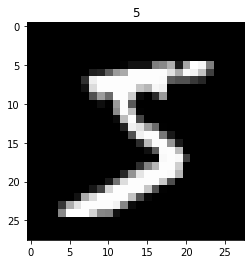

In [8]:
import matplotlib.pyplot as plt 
plt.imshow(train_data.data[0], cmap='gray')
plt.title(f'{train_data.targets[0]}')
plt.show()

## Plot multiple train_data

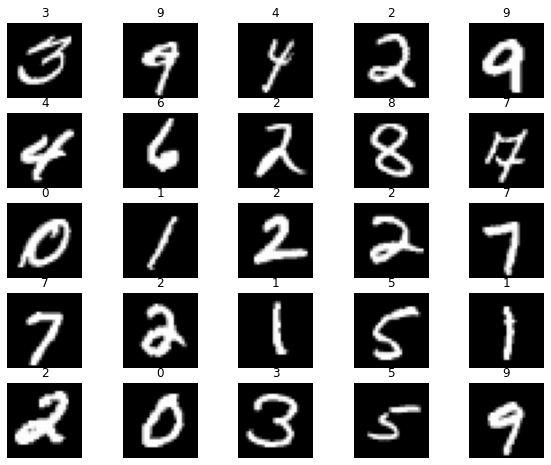

In [12]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label=label)
    plt.axis('off')
   
    plt.imshow(img.squeeze(), cmap='gray')
    
    pass

# Preparing data for training with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [19]:
from torch.utils.data import DataLoader
loaders = {
    'train': torch.utils.data.DataLoader(
        train_data, batch_size=100, shuffle=True, num_workers=1
    ),
    'test': torch.utils.data.DataLoader(
        test_data, batch_size=100, shuffle=False, num_workers=1
    )
}

# Define the Convolutional Neural Network model

A Convolutional Neural Network is type of neural network that is used mainly in image processing applications.

Let us create convolution neural network using torch.nn.Module. torch.nn.Module will be base class for all neural network modules. We will use 2 fully convolutional layers, Relu activation function and MaxPooling.
Conv2d: Applies a 2D convolution over an input signal composed of several input planes.

Parameters

`in_channels` (int) — Number of channels in the input image

`out_channels` (int) — Number of channels produced by the convolution

`kernel_size` (int or tuple) — Size of the convolving kernel

`strid`e (int or tuple, optional) — Stride of the convolution. Default: 1

`padding` (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

`padding_mode` (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

`dilation` (int or tuple, optional) — Spacing between kernel elements. Default: 1

`groups` (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

`bias` (bool, optional) — If True, adds a learnable bias to the output. Default: True

In [15]:
import torch.nn as nn 
class CNN(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2)
        )
        self.out =nn.Linear(32 *7 * 7, 10)
        pass

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x
    pass 

`in_channels=1`: because our input is a grayscale image.

`stride`: is the number of pixels to pass at a time when sliding the convolutional kernel.

`padding`: to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image.

`kernel_size`: we need to define a kernel which is a small matrix of size 5 * 5. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

The `forward()` pass defines the way we compute our output using the given layers and functions.

In [16]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


# Define loss function

In [17]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

# Define optimizer

In [18]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

# Train model

In [21]:
from torch.autograd import Variable
num_epochs = 2

def train(num_epochs, cnn, loaders):
    cnn.train()

    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)

             # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()    
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))   
        pass
    pass

train(num_epochs, cnn, loaders)

Epoch [1/2], Step [100/600], Loss: 0.0819
Epoch [1/2], Step [200/600], Loss: 0.1211
Epoch [1/2], Step [300/600], Loss: 0.0936
Epoch [1/2], Step [400/600], Loss: 0.0247
Epoch [1/2], Step [500/600], Loss: 0.0660
Epoch [1/2], Step [600/600], Loss: 0.1228
Epoch [2/2], Step [100/600], Loss: 0.0298
Epoch [2/2], Step [200/600], Loss: 0.0283
Epoch [2/2], Step [300/600], Loss: 0.0120
Epoch [2/2], Step [400/600], Loss: 0.0062
Epoch [2/2], Step [500/600], Loss: 0.0100
Epoch [2/2], Step [600/600], Loss: 0.0047


# Evaluate the model on test data

We must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.

`model.train()` tells your model that you are training the model. So effectively layers like `dropout`, `batchnorm` etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.

You can call either `model.eval()` or `model.train(mode=False)` to tell that you are testing the model.

In [22]:
def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
test()

Test Accuracy of the model on the 10000 test images: 0.98
